<a href="https://colab.research.google.com/github/carlosmatherson/PolymerGCN/blob/main/TgGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


Install Spektral and RDKit.

In [ ]:
!pip install spektral
!pip install rdkit

Import necessary packages and functions.

In [ ]:
# general tools
import numpy as np
import pandas as pd

# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Spektral
from spektral.utils.sparse import reorder
from spektral.data.graph import Graph
from spektral.data import Dataset, BatchLoader
from spektral.layers import GCNConv, GlobalSumPool

# SciKit-Learn
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

# TensorFlow & Keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Atom Featurization

Onehot Encoding: Maps input elements x which are not in the permitted list to the last element of the permitted list.

In [ ]:
# Onehot Encoding
def one_hot_encoding(x, permitted_list):

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding

Atom Featurization: Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.

In [ ]:
# Atom Featurization
def get_atom_features(atom):

    # Define list of permitted atoms
    permitted_list_of_atoms = ['Br', 'C', 'Cl', 'F', 'Li', 'N', 'O', 'P', 'S', 'Si', '*']
    
    # Compute atom features
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)

    n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])

    implicit_valence_enc = one_hot_encoding(str(atom.GetImplicitValence()), [0, 1, 2, 3, 4, "MoreThanFour"])

    degree_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])

    aromaticity_enc = [int(atom.GetIsAromatic())]

    # Create atom feature vector
    atom_feature_vector = atom_type_enc + n_hydrogens_enc + implicit_valence_enc + degree_enc + aromaticity_enc

    return np.array(atom_feature_vector)

# Create Dataset

Subclass the Dataset class to standardize how graph datasets are represented in Spektral. Here, you can choose the endpoint to work with.

In [ ]:
class MyDataset(Dataset):
  def read(self):

    global polymer_data # Access data globally
    
    # Set of 445 polymers with every endpoint (Tg, Tm, D) curated from Liu et al. (https://arxiv.org/pdf/2206.02886.pdf) 
    polymer_data = pd.read_csv("https://raw.githubusercontent.com/carlosmatherson/PolymerGCN/main/SMILESwithAllProps.csv")
    # Label is "Tg"
    
    # Full dataset from from Liu et al. (https://arxiv.org/pdf/2206.02886.pdf)
    # polymer_data = pd.read_csv("https://raw.githubusercontent.com/liugangcode/GREA/main/data/tg_prop/raw/tg_raw.csv")
    # Label is "tg"
    
    dataset = makeGraphObjList(polymer_data["SMILES"], polymer_data["Tg"]) 
   
    return dataset

Define `makeGraphObjList` to create Spektral graph dataset from smiles and labels. The function takes a list of SMILES strings `x_smiles = [smiles_1, smiles_2, ....]` and a list of numerial labels for the SMILES strings `y = [y_1, y_2, ...]` as inputs. The output is a list of spektral.data.graph.Graph objects that can readily be used for machine learning with Spektral, `graph_list = [G_1, G_2, ...]`. 






In [ ]:
def makeGraphObjList(x_smiles, y):
    
    graph_list = []

    for (smiles, y_val) in zip(x_smiles, y):
        
        # Convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)

        # Avoid O=O
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        
        # Get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))

        # Construct adjacency matrix A of shape(n_nodes, n_nodes)
        A = np.array(GetAdjacencyMatrix(mol)) # full matrix

        # Construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))
        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
                
        # Construct endpoint tensor
        Y = np.array([y_val])

        # Construct Spektral graph object and append to dataset (list)
        graph_list.append(Graph(x=X, a=A, e=None, y=Y))
        
    return graph_list 

Load data.

In [ ]:
data = MyDataset()  # Store data in data

# Helper Functions

Define R-squared function not available through Keras.

In [ ]:
# Coefficient of determination metric
def coeff_determination(y_true, y_pred):
  SS_res =  K.sum(K.square(y_true-y_pred))
  SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
  return (1 - SS_res/(SS_tot + K.epsilon()))

# Graph Convolutional Network

Configure hyperparameters.

In [ ]:
train_split = 0.8                   # Train/Test split
learning_rate = 1e-3                # Learning rate
epochs = 1                       # Number of training epochs, 4000
batch_size = 15                     # Batch size 

num_folds = 5                       # Number of folds for Cross Validation
optimizer = Adam(learning_rate)     # Optimizer
l2 = regularizers.L2(1e-2)          # L2 kernel reg. with weight decay parameter
validation_steps = 5                # Validation steps

loss = 'mse'                        # Loss function
metrics = [RootMeanSquaredError(), 
           coeff_determination]     # Metrics

Define GCN architecture.


In [ ]:
#Model
class myGCN(Model):

    # Define GCN structure
    def __init__(self):
      super().__init__()
      
      # GCN+LR: 6 convolutional layers with 100 nodes each, batch input 0-padded
      self.conv1 = GCNConv(100, activation="relu", kernel_regularizer=l2)  
      self.conv2 = GCNConv(100, activation="relu", kernel_regularizer=l2)  
      self.conv3 = GCNConv(100, activation="relu", kernel_regularizer=l2)  
      self.conv4 = GCNConv(100, activation="relu", kernel_regularizer=l2)
      self.conv5 = GCNConv(100, activation="relu", kernel_regularizer=l2)
      self.conv6 = GCNConv(100, activation="relu", kernel_regularizer=l2)  
      self.global_pool = GlobalSumPool()                        # graph embed
      self.dense1 = Dense(data.n_labels, kernel_regularizer=l2) # GCN out
      
      # GCN+NN: 2 hidden layers with 300 nodes each
      self.mlp1 = Dense(units=300, activation="relu", kernel_regularizer=l2)
      self.mlp2 = Dense(units=300, activation="relu", kernel_regularizer=l2)
      self.dense2 = Dense(data.n_labels, kernel_regularizer=l2) # output       


    # Call GCN 
    def call(self, inputs):

      # global variables for results
      global embed, gcn_out, nn_out

      # Calling GCN
      x, a = inputs[0], inputs[1]
      x = self.conv1([x, a])
      x = self.conv2([x, a])
      x = self.conv3([x, a])
      x = self.conv4([x, a])
      x = self.conv5([x, a])
      x = self.conv6([x, a])
      embed = x = self.global_pool(x)
      gcn_out = self.dense1(x)
      x = self.mlp1(x)
      x = self.mlp2(x)
      nn_out = self.dense2(x)

      # Return loss and metrics for GCN-LR and GCN-NN
      return gcn_out, nn_out


model = myGCN() # Compile model
model.compile(optimizer=optimizer, metrics=metrics, loss=loss, run_eagerly=True)

# Model Training/Testing

Train and evaluate model with 5-fold cross validation

In [ ]:
# Implement 5-fold cross validation with shuffled dataset
k = KFold(n_splits=num_folds, random_state=None, shuffle=True)

loss = [] # array to store loss metrics
i=0       # count to display loss information at end of loop

# Iterate through folds, train data, evaluate model
for train_index, test_index in k.split(data):
  # Split data into training and testing sets
  dataset_tr = data[train_index]  # Kth training set (fold)
  dataset_te = data[test_index]   # Kth testing set (fold)
  
  # Load batch data from datasets with zero-padding and more shuffling
  loader_tr = BatchLoader(dataset_tr, batch_size=batch_size, mask=True, shuffle=True)
  loader_te = BatchLoader(dataset_te, batch_size=batch_size, mask=True, shuffle=True)
  
  # Fit model and store results
  results = model.fit(loader_tr.load(), 
                      steps_per_epoch=loader_tr.steps_per_epoch, 
                      epochs=epochs
  #                 validation_data=loader_te.load(),
  #                 validation_steps=5
  )

  print("\nTesting model") # Show test results for each fold
  # Append loss metrics to array
  loss.append(model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch))
  
  # Output test results
  print("Done. \n\nTest loss: {}".format(loss[i]))
  print("\n")

  i+=1 # increment counter for array
  # End of loop


/usr/local/lib/python3.7/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
/usr/local/lib/python3.7/dist-packages/spektral/layers/convolutional/conv.py:94: UserWarning: The adjacency matrix of dtype <dtype: 'int32'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
  f"The adjacency matrix of dtype {a.dtype} is incompatible with the dtype "


24/24 [==============================] - 2s 90ms/step - loss: 3780.9238 - output_1_loss: 2078.5330 - output_2_loss: 1694.3225 - output_1_root_mean_squared_error: 45.5909 - output_1_coeff_determination: 0.7339 - output_2_root_mean_squared_error: 41.1621 - output_2_coeff_determination: 0.7826

Testing model
6/6 [==============================] - 0s 37ms/step - loss: 4098.9702 - output_1_loss: 2380.7166 - output_2_loss: 1710.1674 - output_1_root_mean_squared_error: 48.7926 - output_1_coeff_determination: 0.6812 - output_2_root_mean_squared_error: 41.3542 - output_2_coeff_determination: 0.7875
Done. 

Test loss: [4098.97021484375, 2380.716552734375, 1710.1673583984375, 48.79258728027344, 0.6811835765838623, 41.35416793823242, 0.7875085473060608]


24/24 [==============================] - 2s 76ms/step - loss: 3773.4397 - output_1_loss: 2086.6169 - output_2_loss: 1678.7188 - output_1_root_mean_squared_error: 45.6795 - output_1_coeff_determination: 0.6987 - output_2_root_mean_squared_error: 4

# Results

In [ ]:
# Create dataframe with results
lossDF = pd.DataFrame(loss, columns = ['Tot. MSE','GCN MSE','NN MSE','GCN RMSE','GCN R^2','NN RMSE','NN R^2'])
lossDF.loc['Mean'] = lossDF.mean()
display(lossDF)

,Tot. MSE,GCN MSE,NN MSE,GCN RMSE,GCN R^2,NN RMSE,NN R^2
0,4098.970215,2380.716553,1710.167358,48.792587,0.681184,41.354168,0.787509
1,3782.981445,2143.242920,1631.618164,46.295170,0.746094,40.393295,0.803912
2,4410.769531,2461.801514,1940.840210,49.616547,0.699540,44.054966,0.756349
3,3127.541504,1741.772705,1377.619141,41.734550,0.738806,37.116291,0.793498
4,2864.783447,1525.808105,1330.799683,39.061592,0.805026,36.480125,0.829787
Mean,3657.009229,2050.668359,1598.208911,45.100089,0.734130,39.879769,0.794211


# Visualization (future work)

Plot root mean square error per epoch.

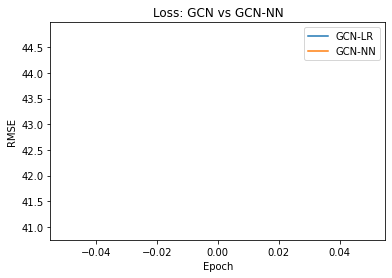

In [ ]:
# Plott RMSE per epoch
fig, ax = plt.subplots()
plt.plot(results.history['output_1_root_mean_squared_error'], label="GCN-LR")
plt.plot(results.history['output_2_root_mean_squared_error'], label="GCN-NN")
plt.title("Loss: GCN vs GCN-NN")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
ax.legend()
plt.show()

Plot coefficient of determination.

In [ ]:
# Plott R^2 

Plot PCA 

In [ ]:
# Create a 2D PCA projection of the embeddings
GCNrepresentation = embed.numpy()
pca = PCA(n_components=2)
pca.fit(GCNrepresentation)
pca_gcn = pca.transform(GCNrepresentation)
print(pca.explained_variance_ratio_)

# Plot those points as a scatter plot 
fig, ax = plt.subplots(figsize=(8,8))
num_categories = data.n_labels
plt.title("PCA from Pooled Graph Embedding")
plt.xlabel("PC1")
plt.ylabel("PC2")
ax.legend()
ax.scatter(pca_gcn[:,0],pca_gcn[:,1]) # c=np.array(cmap(lab)).reshape(1,4)
plt.show()

NameError: ignored